In [1]:
# importing the necessary packages/libraries
import numpy as np
from matplotlib import pyplot as plt
import random
import os
import requests

from PIL import Image as pil_image

import torch
import torchvision
from torchvision import models
import torchvision.transforms as torch_transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

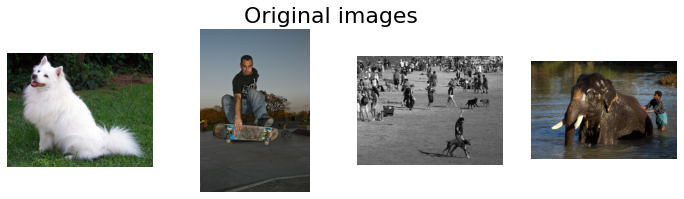

In [3]:
# list of image URLs
urls = [
    'https://github.com/pytorch/hub/raw/master/images/dog.jpg',
    'http://farm4.staticflickr.com/3418/3368475823_74f3d3e9f9_z.jpg', 
    'http://farm3.staticflickr.com/2431/3908162999_5b5cd7c1b7_z.jpg',
    'http://farm8.staticflickr.com/7069/6903096875_042efb5ee7_z.jpg'
]

# Openning the image and visualising it
input_images = [pil_image.open(requests.get(url, stream=True).raw) for url in urls]

fig = plt.figure(figsize=(12, 3))
fig.suptitle('Original images', size=22)
for img_ind, img in enumerate(input_images):
    ax = fig.add_subplot(1, 4, img_ind+1)
    ax.imshow(img)
    ax.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input tensor shape: torch.Size([4, 3, 224, 224])


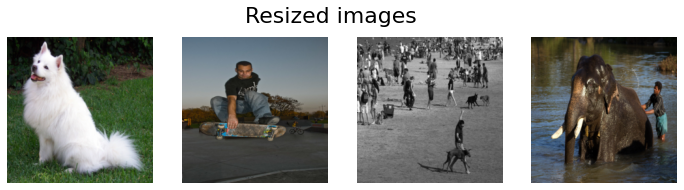

In [4]:
# the training size of ImageNet pretrained networks
target_size = 224
# mean and std values of ImageNet pretrained networks
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# the list of transformation functions
transforsm = torch_transforms.Compose([
    torch_transforms.Resize((target_size, target_size)),
    torch_transforms.ToTensor(),
    torch_transforms.Normalize(mean=mean, std=std)
])

torch_imgs = torch.stack([transforsm(img) for img in input_images])
print("Input tensor shape:", torch_imgs.shape)

# visualising the torch images
fig = plt.figure(figsize=(12, 3))
fig.suptitle('Resized images', size=22)
for img_ind, img in enumerate(torch_imgs):
    ax = fig.add_subplot(1, 4, img_ind+1)
    # inversing the normalisation by multiplying to std and adding mean
    ax.imshow(img.numpy().transpose(1, 2, 0) * std + mean)
    ax.axis('off')

In [5]:
network = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1).to(device)
network.eval()

# getting the name of layers, which we use later to obtain their activation maps
layer_names = [key for key, _ in network.named_children()]
print(layer_names)

['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']


In [6]:
def activation(name, acts_dict):
    """Storing the output of a module/layer in the dict that is passed as an argument."""
    def hook(model, input_x, output_y):
        acts_dict[name] = output_y.detach()
    return hook

def create_hooks(model, layers):
    """For the given model it creates a hook for all specified layers."""
    acts_dict = dict()
    hooks = dict()
    for layer_name in layers:
        # accessing the layer/module from the network
        layer = getattr(model, layer_name)
        hooks[layer_name] = layer.register_forward_hook(activation(layer_name, acts_dict))
    return acts_dict, hooks

In [7]:
acts_dict, hooks = create_hooks(network, ['maxpool', 'layer2', 'fc'])

In [8]:
_ = network(torch_imgs.to(device))

In [9]:
for layer_name, layer_acts in acts_dict.items():
    print(layer_name, layer_acts.shape)

maxpool torch.Size([4, 64, 56, 56])
layer2 torch.Size([4, 512, 28, 28])
fc torch.Size([4, 1000])


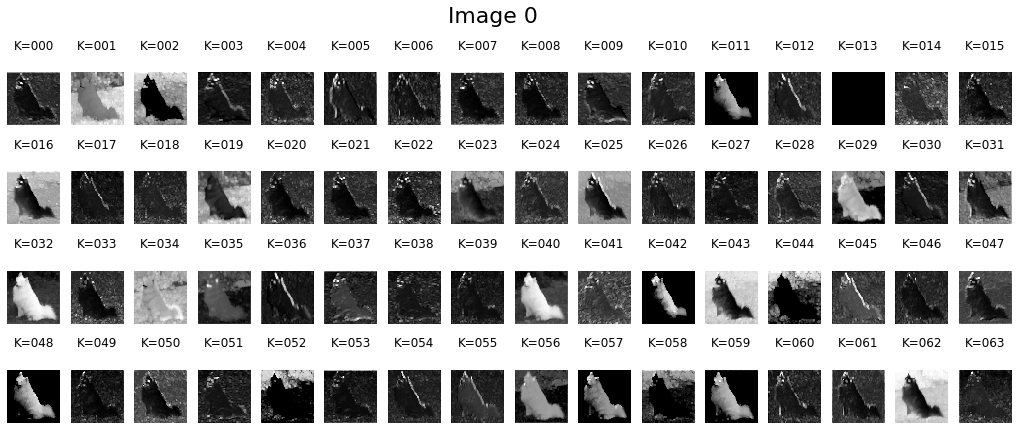

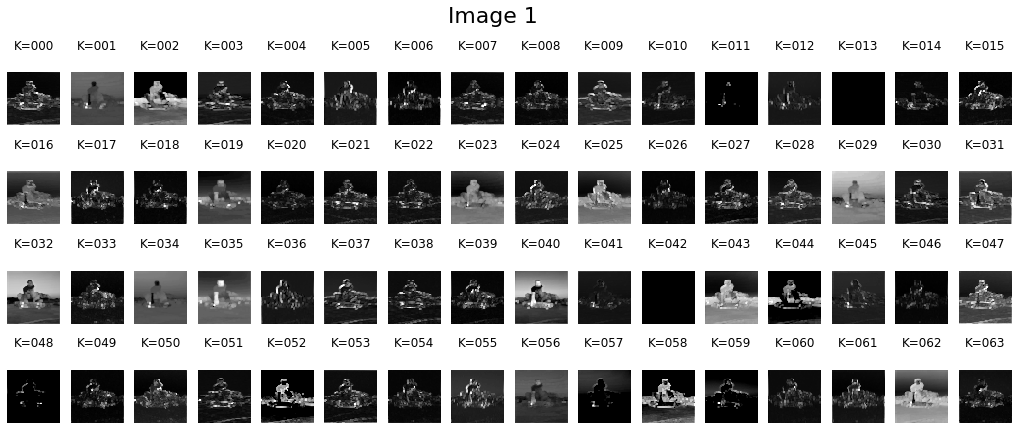

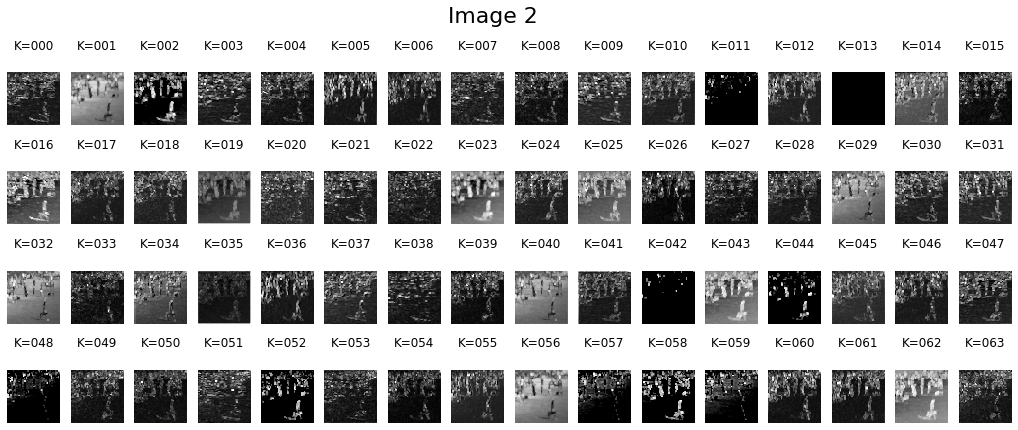

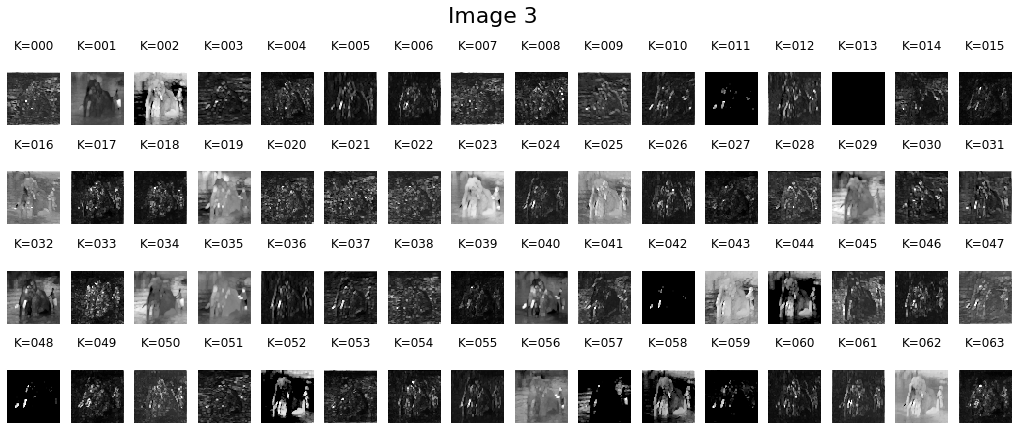

In [10]:
layer_act = acts_dict['maxpool']
for img_ind, layer_acts in enumerate(layer_act):
    fig = plt.figure(figsize=(18, 7))
    fig.suptitle('Image %d' % img_ind, size=22)
    cols = 16
    rows = layer_acts.shape[0] // cols
    for kernel_ind, kernel_act in enumerate(layer_acts.detach().cpu()):
        ax = fig.add_subplot(rows, cols, kernel_ind+1)
        ax.matshow(kernel_act, cmap='gray')
        ax.set_title('K=%.3d' % kernel_ind)
        ax.axis('off')

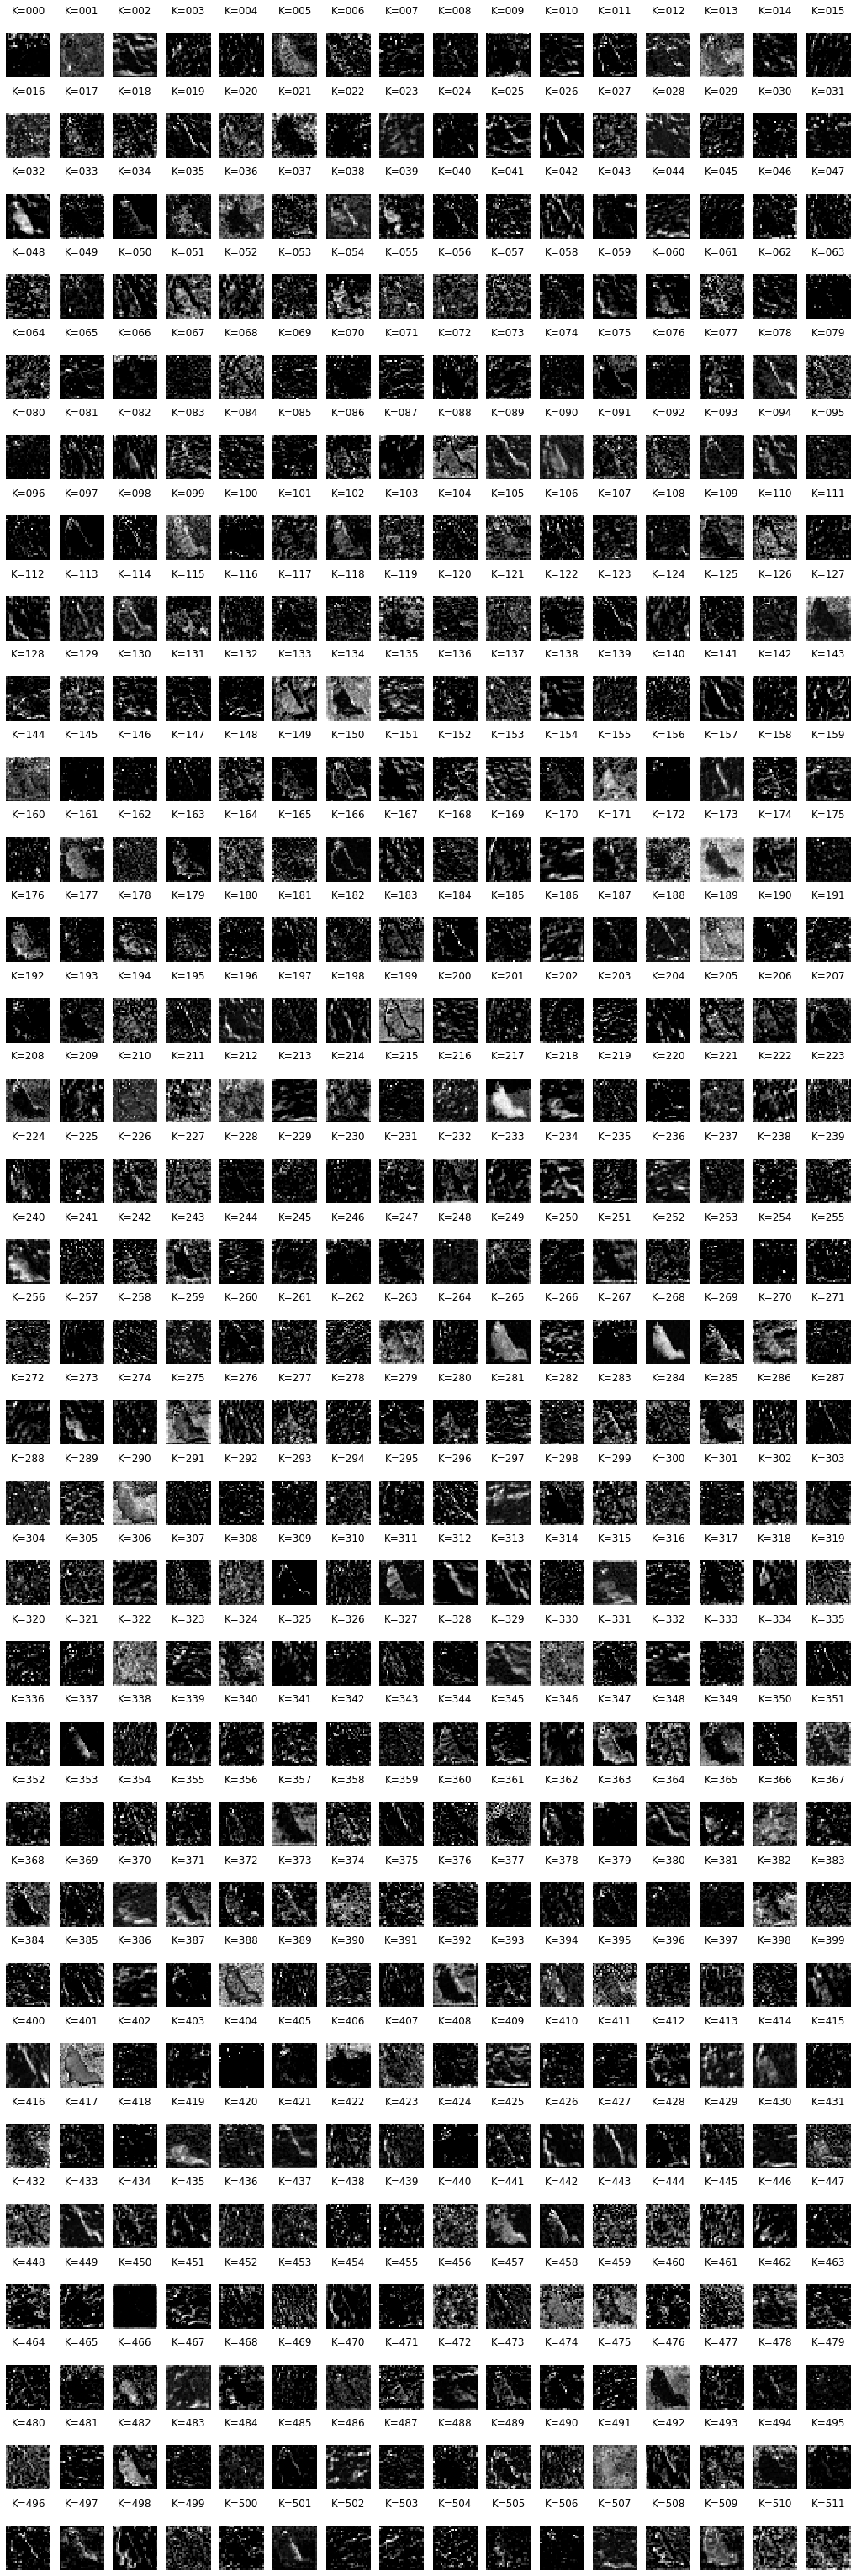

In [11]:
layer_act = acts_dict['layer2']
for img_ind, layer_acts in enumerate(layer_act):
    fig = plt.figure(figsize=(18, 56))
    cols = 16
    rows = layer_acts.shape[0] // cols
    for kernel_ind, kernel_act in enumerate(layer_acts.detach().cpu()):
        ax = fig.add_subplot(rows, cols, kernel_ind+1)
        ax.matshow(kernel_act, cmap='gray')
        ax.set_title('K=%.3d' % kernel_ind)
        ax.axis('off')
    break